# Project 1 - Binary Image Classification

# 1. Install Dependencies and Setup

In [37]:
!pip install opencv-python matplotlib 

In [38]:
!pip list

Package                       Version
----------------------------- --------
absl-py                       1.4.0
asttokens                     2.2.1
astunparse                    1.6.3
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
cachetools                    5.3.1
certifi                       2023.5.7
charset-normalizer            3.2.0
colorama                      0.4.6
contourpy                     1.1.0
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.1
executing                     1.2.0
flatbuffers                   23.5.26
fonttools                     4.41.0
gast                          0.4.0
google-auth                   2.22.0
google-auth-oauthlib          0.4.6
google-pasta                  0.2.0
grpcio                        1.56.0
h5py                          3.9.0
idna                          3.4
importlib-metadata            6.8.0
importlib-resources           6.0.0
ipykernel       

In [39]:
import tensorflow as tf
import keras.api._v2.keras as keras
import os

# 2. Remove Dodgy Images

In [40]:
import cv2
import imghdr

In [41]:
data_dir = 'data'

In [42]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [43]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# 3. Load Data

In [44]:
import numpy as np
from matplotlib import pyplot as plt

In [45]:
data = keras.utils.image_dataset_from_directory('data')

Found 300 files belonging to 2 classes.


In [46]:
data_iterator = data.as_numpy_iterator()

In [47]:
batch = data_iterator.next()

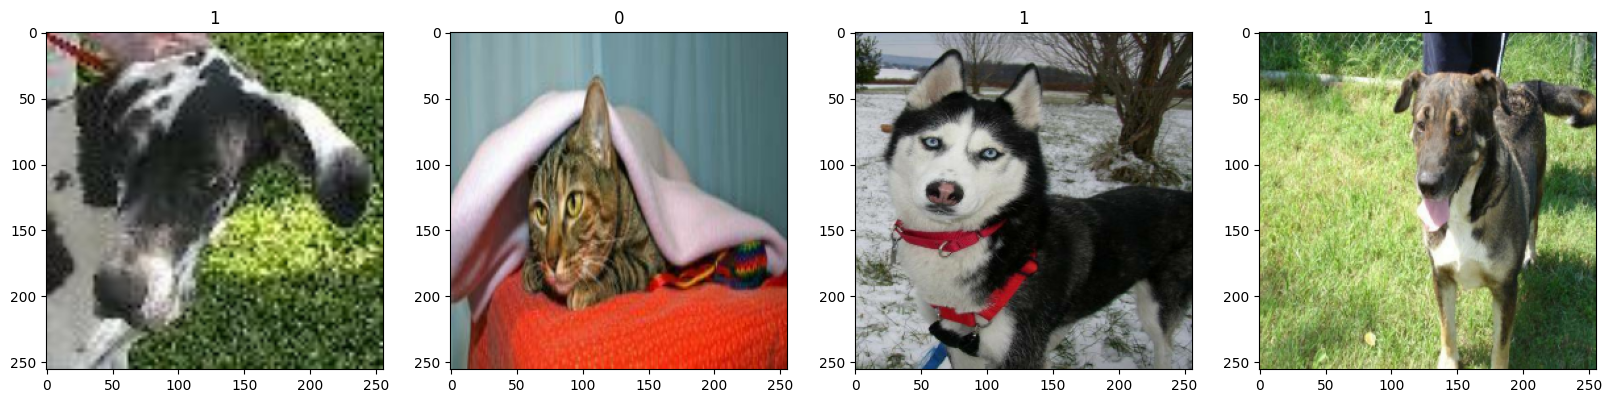

In [48]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [49]:
data = data.map(lambda x,y: (x/255,y))

In [55]:
data.as_numpy_iterator().next()

(array([[[[0.67574704, 0.80908036, 0.84829605],
          [0.7118459 , 0.8451792 , 0.8843949 ],
          [0.72347075, 0.85680413, 0.8960198 ],
          ...,
          [0.9852175 , 0.9734528 , 0.9460018 ],
          [0.97133887, 0.97133887, 0.9321232 ],
          [0.9748297 , 0.9748297 , 0.935614  ]],
 
         [[0.69350946, 0.8268428 , 0.86605847],
          [0.7030459 , 0.83637923, 0.8755949 ],
          [0.7058824 , 0.8392157 , 0.8784314 ],
          ...,
          [0.9909467 , 0.979182  , 0.951731  ],
          [0.9858149 , 0.9858149 , 0.94659925],
          [0.9891598 , 0.9891598 , 0.94994414]],
 
         [[0.6884001 , 0.8217334 , 0.8609491 ],
          [0.6992573 , 0.83259064, 0.8718063 ],
          [0.69459575, 0.8279291 , 0.86714476],
          ...,
          [1.        , 0.9888327 , 0.96138173],
          [0.99155945, 0.99155945, 0.95234376],
          [0.9936121 , 0.9936121 , 0.9543964 ]],
 
         ...,
 
         [[0.32483903, 0.29053167, 0.29261127],
          [0.33747

# 5. Split Data

In [56]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) 

In [57]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [58]:
print([train_size, val_size, test_size])

[7, 2, 1]


# 6. Building Deep Learning Model

In [59]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [60]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [61]:
model = Sequential()

In [63]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [64]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [65]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        4

# 7. Train

In [66]:
logdir = 'logs'

In [67]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [68]:
print(train)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [69]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
7/7 [==============================] - 79s 6s/step - loss: 0.6960 - accuracy: 0.4509 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/5
7/7 [==============================] - 35s 5s/step - loss: 0.6901 - accuracy: 0.5357 - val_loss: 0.6795 - val_accuracy: 0.5938
Epoch 3/5
7/7 [==============================] - 46s 6s/step - loss: 0.6866 - accuracy: 0.4911 - val_loss: 0.6775 - val_accuracy: 0.7500
Epoch 4/5
7/7 [==============================] - 24s 3s/step - loss: 0.6828 - accuracy: 0.5848 - val_loss: 0.6636 - val_accuracy: 0.6562
Epoch 5/5
7/7 [==============================] - 18s 2s/step - loss: 0.6709 - accuracy: 0.6339 - val_loss: 0.6799 - val_accuracy: 0.5781


# 8. Plot Performance

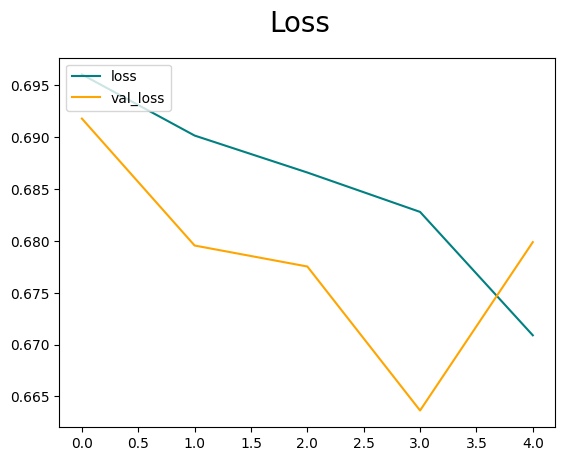

In [70]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

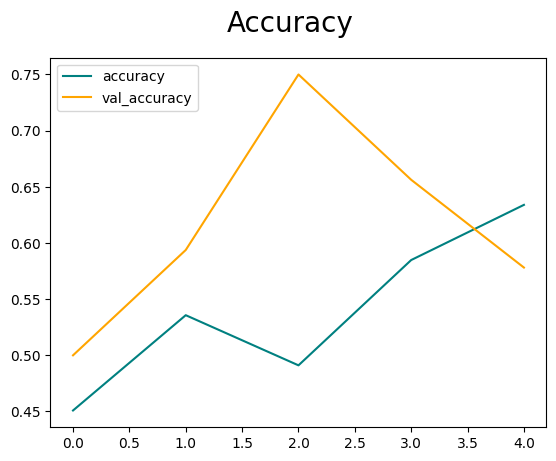

In [71]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 9. Evaluate

In [72]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [73]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [74]:
for batch in test.as_numpy_iterator():
    x,y = batch
    pred = model.predict(x)
    pre.update_state(y, pred)
    re.update_state(y, pred)
    acc.update_state(y, pred)

1/1 [==============================] - 2s 2s/step


In [75]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

0.7 1.0 0.75


# 10. Test

In [76]:
import cv2

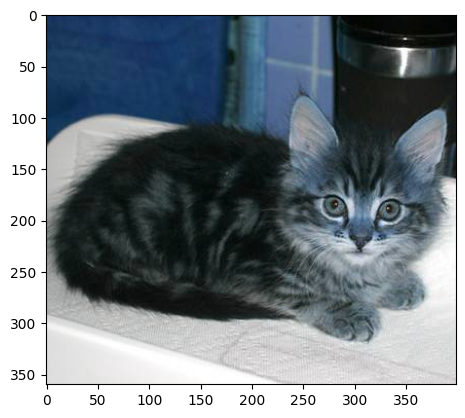

In [101]:
img = cv2.imread('cat_cute.jpg')
plt.imshow(img)
plt.show()

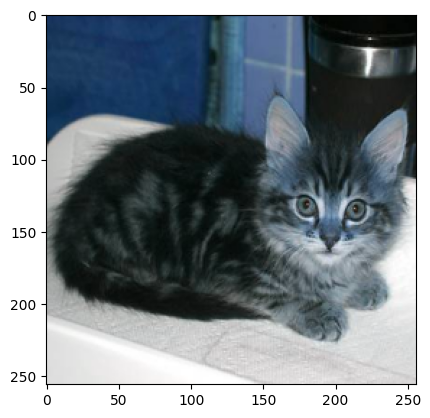

In [102]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [103]:
y_pred = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 484ms/step


In [104]:
y_pred

array([[0.49773103]], dtype=float32)

In [91]:
if y_pred > 0.5:
    print(f'Predicted class is a dog')
else:
    print(f'Predicted class is a cat')

Predicted class is a cat


# 11. Save Model

In [92]:
from tensorflow.keras.models import load_model

In [93]:
model.save(os.path.join('models', 'W1_Proj1.h5'))

# 12.0 Deploy Model to make Prediction

- without preforming training

In [94]:
load_model = load_model('./models/W1_Proj1.h5')

In [95]:
load_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 2s 2s/step


array([[0.49773103]], dtype=float32)

In [96]:
if y_pred > 0.5:
    print(f'Predicted class is a dog')
else:
    print(f'Predicted class is a cat')

Predicted class is a cat
